In [59]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 24 02:24:12 2019

@author: Admin
"""

import pandas as pd
import numpy as np

from scipy.signal import savgol_filter, argrelextrema
import openpyxl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

import pickle
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

import warnings,os
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.dates as mdates
import datetime as dt
import csv

import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams

path="C:\\Users\\Admin\\Documents\\"

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [60]:
def CreateData(dataFrame):
    dataset =np.array( dataFrame.iloc[:, 0:654])
    target = dataFrame.loc[:,['label']]
    target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
    target =target.astype('int32')   
    target.transpose()
    return dataset,target

In [61]:
#сохранение
def saveModel(score,path,nameModel):
    save=False
    dateFile = os.listdir(path)
    name=path+ str(score)+'_'+nameModel+'.pkl'
    for item in dateFile:
        temp=item.split('_')
        if len(temp)==2:
            if (temp[1].find(nameModel)!=-1):
                if (float(temp[0])<score):
                    print("Модель",nameModel,"сохранена\n")
                    save=True
                break
    else:
        save=True
    return save,name

In [62]:
path="C:\\Users\\admin\\Downloads\\Telegram Desktop\\new_sav_filter_data_scaled.xlsx"
dataFrame = pd.read_excel(path)
path="C:\\Users\\Admin\\Documents\\PythonRamanNew\\"
clear_data, target=CreateData(dataFrame)


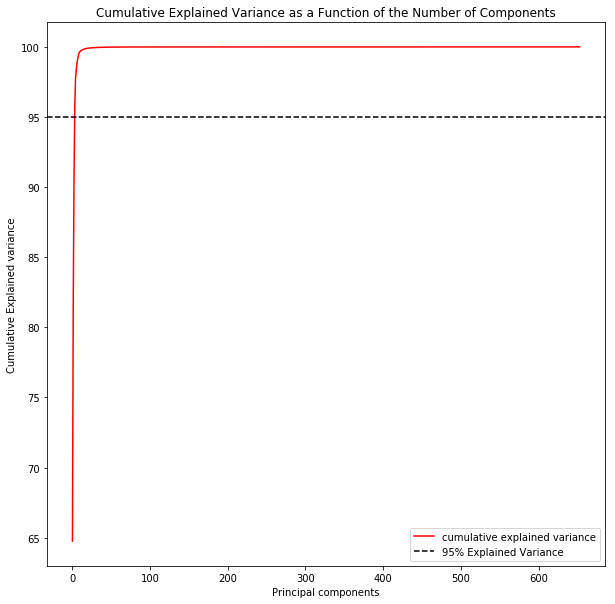

In [63]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(clear_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

Best parameter (CV score=0.591):
{'logistic__C': 0.0001, 'pca__n_components': 11}


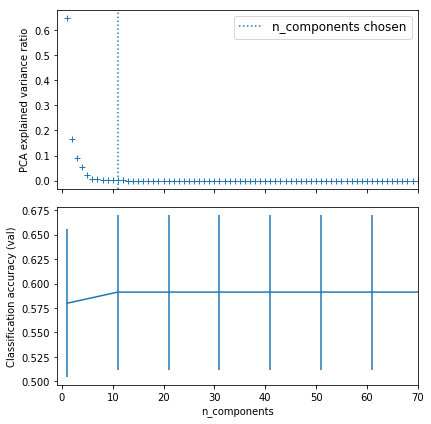

In [64]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [item for item in range(1,651,10)],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
# search = GridSearchCV(pipe, param_grid, cv=5, verbose=True,n_jobs=-1)
search.fit(clear_data, target)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(clear_data)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

# clear_data = pca.transform(clear_data)
pca_2 = PCA(n_components =search.best_estimator_.named_steps['pca'].n_components).fit(clear_data)
clear_data = pca_2.transform(clear_data)

# print ('Mean vector: ', pca_2.mean_)
# print ('Projection: ', pca_2.components_)
# print ('Explained variance ratio: ', pca_2.explained_variance_ratio_)

In [32]:
normalized_train_dataset ,  normalized_test_dataset ,  train_target,  test_target =train_test_split(clear_data,target, test_size=0.30,stratify=target)
train_target = train_target.ravel()
test_target = test_target.ravel()
spec=[]
ch=[]

# Support Vector Classification

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.400593471810089 0.8 

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
   max_iter=-1, nu=0.8, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)
[[ 36  95]
 [ 19 140]]
Специфичность 0.2748091603053435
Чувствительность 0.8805031446540881
--------------
f1ScoreWeighted= 0.5644986250938719
f1ScoreMacro= 0.5488783363353529
f1ScoreBinary= 0.7106598984771574
Точноть 0.6068965517241379


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    2.6s finished


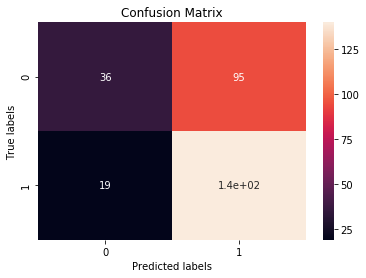

In [33]:
from sklearn.svm import NuSVC

nuSVC=NuSVC()

#GridSearchCV
#----------------------------------------------------------------------
tuned_parameters = {'nu':np.arange(.05,0.95,0.05)}
nu_svc = GridSearchCV(nuSVC,param_grid=tuned_parameters,cv=5, verbose=True)
nu_svc.fit(normalized_train_dataset, train_target)
best_parameter_nu = nu_svc.best_estimator_.nu
best_cv_err = 1 - nu_svc.best_score_
print (best_cv_err, best_parameter_nu,"\n")

#Обучение модели с оптимальными параметрами
NuSVC2 = NuSVC(gamma='scale',nu=best_parameter_nu,probability=True)
NuSVC2.fit(normalized_train_dataset, train_target)
print(NuSVC2)
#предсказание
expected = test_target
predicted = NuSVC2.predict(normalized_test_dataset)
predicted_NuSVC2=predicted
expected_NuSVC2_traine = train_target
predicted_NuSVC2_train = NuSVC2.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=NuSVC2.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score=[buff_score]
NameModel=["nuSVC"]
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])

if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(NuSVC2, fid)

# Дерево принятия решений

# Логическая регрессия

Логическая регрессия

0.4080118694362018 2 

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[ 36  95]
 [ 15 144]]
Специфичность 0.2748091603053435
Чувствительность 0.9056603773584906
--------------
f1ScoreWeighted= 0.5754463869175358
f1ScoreMacro= 0.5596112430283284
f1ScoreBinary= 0.7236180904522613
Точноть 0.6206896551724138
Модель lgModel сохранена



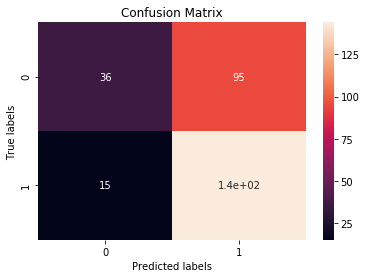

In [34]:
from sklearn.linear_model import LogisticRegression
#Логическая регрессия
print("Логическая регрессия\n")

#GridSearchCV
tuned_parameters = {'C': list(range(1,150))}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter = grid.best_estimator_.C
print (best_cv_err2, best_parameter,"\n")

#Обучение модели с оптимальными параметрами
lgModel = LogisticRegression(C=best_parameter)
print(lgModel)
lgModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = lgModel.predict(normalized_test_dataset)
predicted_lgModel=predicted
expected_lgModel_traine = train_target
predicted_lgModel_train = lgModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=lgModel.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score.append(buff_score)
NameModel.append("lgModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(lgModel, fid)

# Создание модели КNN

КNN

0.42136498516320475 26 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=26, p=2,
           weights='uniform')
[[ 60  71]
 [ 59 100]]
Специфичность 0.4580152671755725
Чувствительность 0.6289308176100629
--------------
f1ScoreWeighted= 0.5491159874608149
f1ScoreMacro= 0.543030303030303
f1ScoreBinary= 0.606060606060606
Точноть 0.5517241379310345


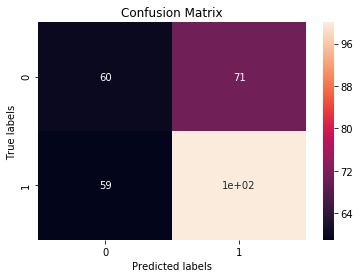

In [35]:
#Создание модели КNN
from sklearn.neighbors import KNeighborsClassifier
print("КNN\n")
#----------------------------------------------------------------------
#GridSearchCV
tuned_parameters= list(range(1,30))
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, param_grid={'n_neighbors': tuned_parameters},cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print (best_cv_err, best_n_neighbors,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

knnModel = KNeighborsClassifier(n_neighbors=best_n_neighbors)
print(knnModel)
knnModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = knnModel.predict(normalized_test_dataset)
predicted_knnModel=predicted

expected_knnModel_traine = train_target
predicted_knnModel_train = knnModel.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_knnModel)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')   

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=knnModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("knnModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(knnModel, fid)

# Случайный лес

err= 0.38724035608308605  best_n_estimators= 67  max_features= 1 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=67, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
[[ 61  70]
 [ 58 101]]
Специфичность 0.46564885496183206
Чувствительность 0.6352201257861635
--------------
f1ScoreWeighted= 0.5560526645768026
f1ScoreMacro= 0.550060606060606
f1ScoreBinary= 0.6121212121212122
Точноть 0.5586206896551724


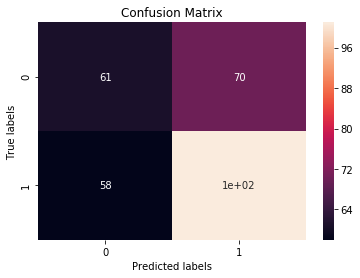

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import roc_auc_score         
#----------------------------------------------------------------------
#GridSearchCV
RDF_model = ensemble.RandomForestClassifier()
tuned_parameters={'n_estimators': np.arange(10,100),'max_features':np.arange(1,5)}
grid = GridSearchCV(RDF_model, param_grid=tuned_parameters,cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_estimators = grid.best_estimator_.n_estimators
best_max_features = grid.best_estimator_.max_features
print ('err=',best_cv_err, " best_n_estimators=",best_n_estimators, " max_features=",best_max_features,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

RDF_grid_model = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, oob_score=True)
RDF_grid_model.fit(normalized_train_dataset, train_target)
print(RDF_grid_model)
expected = test_target
predicted_RDF = RDF_grid_model.predict(normalized_test_dataset)

expected_RDF_grid_traine = train_target
predicted_RDF_grid_train = RDF_grid_model.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(test_target, predicted_RDF)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_RDF, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_RDF, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_RDF, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=RDF_grid_model.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("RDF")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(RDF_grid_model, fid)

# Наивный Байес

Наивный Байес

GaussianNB(priors=None, var_smoothing=1e-09)
[[ 28 103]
 [ 15 144]]
Специфичность 0.21374045801526717
Чувствительность 0.9056603773584906
--------------
f1ScoreWeighted= 0.5343072306211426
f1ScoreMacro= 0.51559934318555
f1ScoreBinary= 0.70935960591133
Точноть 0.593103448275862
Модель nbModel сохранена



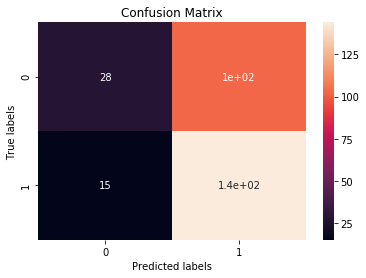

In [37]:
#Использование модели Наивный Байес
print("Наивный Байес\n")
from sklearn.naive_bayes import GaussianNB
#----------------------------------------------------------------------

nbModel = GaussianNB()
nbModel.fit(normalized_train_dataset, train_target)
print(nbModel)
expected = test_target
predicted = nbModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------') 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результы
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=nbModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("nbModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(nbModel, fid)

# Взвешенное голосование
RDF knn lg

0.7329376854599406
0.9465875370919882
0.9406528189910979 

0.6137931034482759
0.6
0.6172413793103448 

VotingClassifier(estimators=[('RDF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=True, n_jobs=None, voting='soft', weights=None)
[[ 47  84]
 [ 27 132]]
Специфичность 0.35877862595419846
Чувствительность 0.8301886792452831
--------------
f1ScoreWeighted= 0.5931182506307822
f1ScoreMacro= 0.5812682926829268
f1ScoreBinary= 0.7040000000000001
Точноть 0.6172413793103448
Модель VotingClassifier3 сохранена



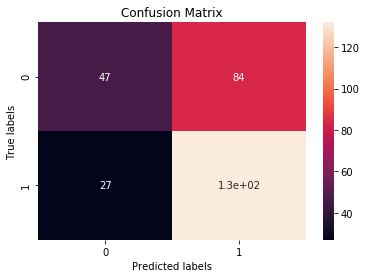

In [65]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel),
                                     ('lg', lgModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)


# eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
#                                      ('lg', lgModel),],
#                                     voting='soft', flatten_transform=True)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),],
                                    voting='soft', flatten_transform=True)

eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier3 = eclf3.predict(normalized_test_dataset)
print(eclf3)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted_VotingClassifier3)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['О', 'К']); 
# ax.yaxis.set_ticklabels(['О', 'К']);
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted_VotingClassifier3)

f1ScoreMacro_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='macro')
print("f1ScoreMacro=",f1ScoreMacro_VotingClassifier3)
      
f1ScoreBinary_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='binary')
print("f1ScoreBinary=",f1ScoreBinary_VotingClassifier3)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier3")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(eclf3, fid)

No handles with labels found to put in legend.


[0.6068965517241379, 0.6206896551724138, 0.5517241379310345, 0.5586206896551724, 0.593103448275862, 0.596551724137931, 0.6172413793103448]
['nuSVC', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier3', 'VotingClassifier3']


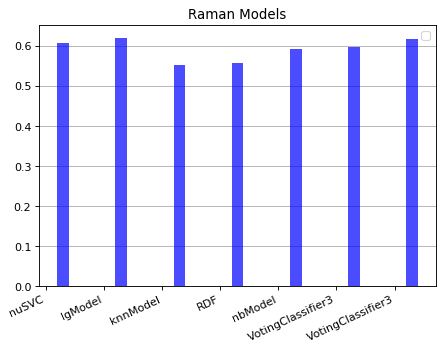

In [66]:
print(Score)
print(NameModel)
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.555979381443296]
# NameModel=['SVC', 'CART', 'LR', 'KNN','RDF','NB']
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.28865979381443296, 0.7520000000000001, 0.7365269461077845, 0.8010471204188482, 0.6909090909090908, 0.7152941176470589, 0.702127659574468, 0.7136150234741784]
# NameModel=['nuSVC', 'cartModel', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier1', 'VotingClassifier2', 'VotingClassifier3', 'stacker_Ridge', 'stacker Log Reg', 'stackerknnModel', 'stacker_RDF_grid']

from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Raman Models')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], Score,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('Score.png')

No handles with labels found to put in legend.


[2748.0916030534354, 2748.0916030534354, 4580.152671755725, 4656.488549618321, 2137.4045801526718, 3435.1145038167942, 35.87786259541985]


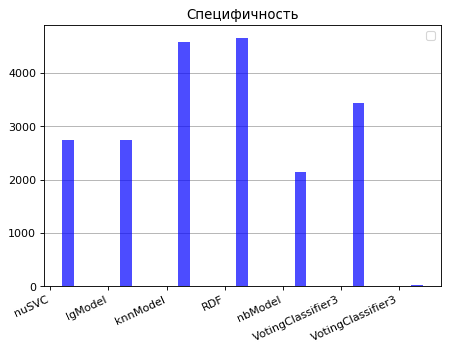

In [67]:
spec=[i * 100 for i in spec]
print(spec)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Специфичность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], spec,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('spec.png')

No handles with labels found to put in legend.


[8805.031446540881, 9056.603773584906, 6289.308176100629, 6352.201257861635, 9056.603773584906, 8050.314465408806, 83.01886792452831]


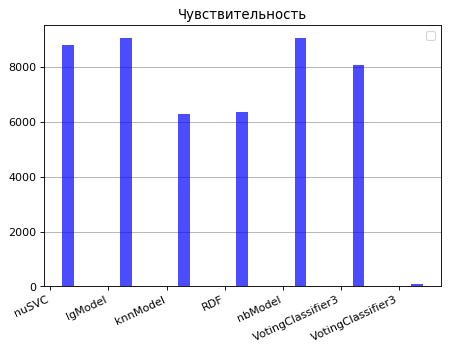

In [68]:
ch=[i * 100 for i in ch]
print(ch)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Чувствительность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], ch,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('ch.png')

In [42]:
print(len(normalized_test_dataset[0]))
print(len(normalized_test_dataset))
print(normalized_test_dataset)

11
290
[[-3.42851955e+00  3.73734777e-02 -6.67606011e-01 ...  1.80992001e-01
   3.52255526e-02 -1.68923464e-01]
 [-1.17651006e+00 -5.70519140e-01 -3.62075203e-01 ... -9.96698058e-02
  -1.41739572e-01  1.71949880e-03]
 [ 3.27825506e+00 -6.95647880e-01  9.12713510e-01 ... -8.40915626e-02
   2.73122627e-02 -1.12783054e-02]
 ...
 [-9.37862480e-01 -7.14516217e-01  5.62222327e-01 ... -1.55838283e-01
  -1.00943376e-01  1.08432898e-01]
 [-2.39209936e+00 -6.60767976e-01  1.73565447e-01 ... -2.95335234e-01
  -7.02026850e-02 -7.20842022e-02]
 [-1.60831838e-01 -2.39644289e-01 -1.14147401e+00 ... -2.28565268e-01
  -1.93495152e-01 -2.22596662e-01]]
